# Railgun Model

Thomas Jagielski and Duncan  Mazza

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

import math

Assumptions:

    - Constant Current
    - Constant Force
    - The rails are made of iron
    - Projectile is a baseball
   


In [2]:
params = Params(mass_proj = 0.145, #kg
                #mass_proj = 50, #kg
                rail_r = 0.01, #m
                rail_l = 3, #m
                arm_w = 0.9, #m
                arm_l = 0.01, #m
                arm_d = 0.02, #m
                w = 0.1, #m
                #mu = 1150, #T  
                mu = 10, 
                rho_cu = 8960, #g/m^3
                v_init = 0, #m/s
                y_init = 0, #m
                t_end = 1000
                )

,values
mass_proj,0.145
rail_r,0.010
rail_l,3.000
arm_w,0.900
arm_l,0.010
arm_d,0.020
w,0.100
mu,10.000
rho_cu,8960.000
v_init,0.000


In [3]:
def make_system(params):
    """Make a system object.
    
    params: 
    
    returns: System object
    """

    unpack(params)
    
    mass_arm = (arm_w * arm_l * arm_d) * rho_cu

    current = 200
    
    lorentz_force = ((mu * current**2)/(2 * np.pi)) * (math.log((rail_r + w) / rail_r))
    B = ((mu * current)/(2 * np.pi * w)) * (math.log((rail_r + w) / rail_r))
    
    init = State(v=v_init, y=y_init)
    
    return System(params, lorentz_force=lorentz_force, mass_arm = mass_arm, B = B, init=init)

In [4]:
system = make_system(params);

In [5]:
def slope_func(state, t, system):
    
    unpack(system)
    v, y = state
    
    emf = -B * v * w   
    dvdt = (lorentz_force + emf) / (mass_proj + mass_arm)
    dydt = v
        
    return dvdt, dydt

In [6]:
slope_func(system.init, 0, system)

(86844.2111008191, 0.0)

In [7]:
def event_func(state, t, system):
    v, y = state
    return system.rail_l - y

In [8]:
results, details = run_ode_solver(system, slope_func, events = event_func, max_step=0.00001)
details

,values
sol,None
t_events,[[0.017301716880873133]]
nfev,10388
njev,0
nlu,0
status,1
message,A termination event occurred.
success,True


In [9]:
results

,v,y
0.000000,0.000000,0.000000
0.000010,0.866559,0.000004
0.000020,1.729364,0.000017
0.000030,2.588430,0.000039
0.000040,3.443775,0.000069
0.000050,4.295413,0.000108
0.000060,5.143361,0.000155
0.000070,5.987635,0.000211
0.000080,6.828251,0.000275
0.000090,7.665225,0.000347


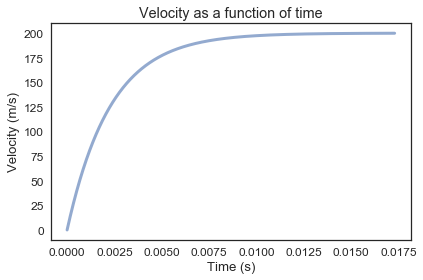

In [10]:
plot(results.v)

decorate(xlabel='Time (s)',
         ylabel='Velocity (m/s)',
         title='Velocity as a function of time',
         legend=False)

### Projectile Motion 

In [42]:
params_proj = Params(x = get_last_value(results.v), #m 
                     y = 1, #m
                     g = 9.8, #m/s^2
                     mass = 145e-3, #kg
                     diameter = 73e-3, #m
                     rho = 1.2, #kg/m^3
                     C_d = 0.33,
                     angle = 45, #degree
                     velocity = 40, #m / s
                     t_end = 10 #s
                     )

,values
x,199.855365
y,1.000000
g,9.800000
mass,0.145000
diameter,0.073000
rho,1.200000
C_d,0.330000
angle,45.000000
velocity,40.000000
t_end,10.000000


In [43]:
def make_system_proj(params):
    """Make a system object.
    
    params: Params object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(params)
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, velocity)
    
    # make the initial state
    init = State(x=x, y=y, vx=vx, vy=vy)
    
    # compute area from diameter
    area = np.pi * (diameter/2)**2
    
    return System(params, init=init, area=area)

In [44]:
system_proj = make_system_proj(params_proj)

,values
x,199.855
y,1
g,9.8
mass,0.145
diameter,0.073
rho,1.2
C_d,0.33
angle,45
velocity,40
t_end,10


In [45]:
m = UNITS.meter
s = UNITS.second

baseball_drag = pd.read_csv('data/baseball_drag.csv')
baseball_drag.index = Quantity(baseball_drag['Velocity in mph'].values, UNITS.mph).to(m/s)
baseball_drag

,Velocity in mph,Drag coefficient
0.026146,0.058486,0.49965
8.871509,19.845000,0.49878
17.647351,39.476000,0.49704
22.432914,50.181000,0.48225
26.882303,60.134000,0.45004
30.636992,68.533000,0.40914
32.977694,73.769000,0.38042
34.604472,77.408000,0.36562
37.497268,83.879000,0.34822
40.460249,90.507000,0.33081


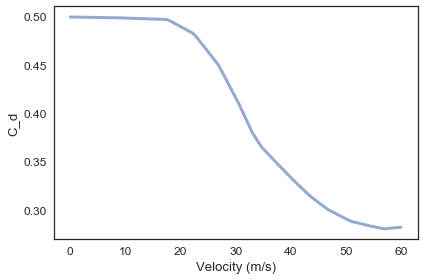

In [46]:
drag_interp = interpolate(baseball_drag['Drag coefficient'])
vs = linspace(0, 60, 101)
cds = drag_interp(vs)
plot(vs, cds)
decorate(xlabel = 'Velocity (m/s)', ylabel = 'C_d')

In [47]:
def drag_force(v, system):
    """finds drag force in the opposing direction to velocity
    
    v: velocity
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    
    unpack(system)
    C_d = drag_interp(v.mag)
    mag = -rho * v.mag ** 2 * C_d * area / 2
    direction = v.hat()
    f_drag = direction * mag
    return f_drag

In [48]:
def slope_func_proj(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)

    v = Vector(vx, vy)    
    a_drag = drag_force(v, system) / mass
    a_grav = Vector(0, -g)
    
    a = a_grav + a_drag
    
    return vx, vy, a.x, a.y

In [49]:
slope_func_proj(system_proj.init, 0, system_proj)

(28.284271247461902,
 28.284271247461902,
 <Quantity(-6.534891184395127, 'dimensionless')>,
 <Quantity(-16.334891184395126, 'dimensionless')>)

In [50]:
def event_func_proj(state, t, system):
    """Stop when the y coordinate is 0.
    
    state: State object
    t: time
    system: System object
    
    returns: y coordinate
    """
    x, y, vx, vy = state
    return y

In [51]:
event_func_proj(system_proj.init, 0, system_proj)

1.0

In [60]:
system_proj = System(system_proj, drag_interp = drag_interp)
results_proj, details_proj = run_ode_solver(system_proj, slope_func_proj, 
                                            events = event_func_proj, method = 'RK23')
details_proj

,values
sol,None
t_events,[[4.921756139260461]]
nfev,32
njev,0
nlu,0
status,1
message,A termination event occurred.
success,True


In [61]:
results_proj

,x,y,vx,vy
0.000000,199.855365,1.000000e+00,28.284271,28.284271
0.008911,200.107153,1.251399e+00,28.226128,28.138889
0.098023,202.596847,3.694752e+00,27.654743,26.704824
0.485287,212.856304,1.288794e+01,25.379078,20.868959
1.074051,226.891280,2.280169e+01,22.379032,12.977703
1.861345,243.250106,2.939851e+01,19.326098,4.012713
2.648639,257.552588,2.945452e+01,17.079977,-3.721733
3.435933,270.229046,2.377638e+01,15.144361,-10.567638
4.512710,285.149928,8.035028e+00,12.591423,-18.402335
4.921756,290.105044,-1.776357e-15,11.646245,-20.876688


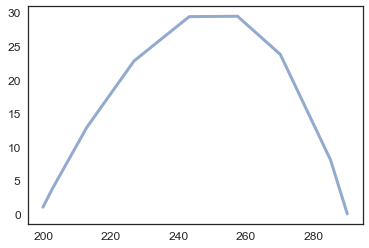

In [62]:
plot(results_proj.x, results_proj.y)